In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [3]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

C:\Users\okso6\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
X.shape, y.shape

((1309, 13), (1309,))

In [4]:
rng = np.random.RandomState(seed=42)
rng

RandomState(MT19937) at 0x2258875AD08

In [6]:
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,random_cat,random_num
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",2,-1.110576
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1.752270
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",2,0.935678
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",2,1.271555
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0,0.721672


In [7]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]
X.head()

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
0,1.0,female,S,2,29.0000,0.0,0.0,211.3375,-1.110576
1,1.0,male,S,0,0.9167,1.0,2.0,151.5500,1.752270
2,1.0,female,S,2,2.0000,1.0,2.0,151.5500,0.935678
3,1.0,male,S,2,30.0000,1.0,2.0,151.5500,1.271555
4,1.0,female,S,0,25.0000,1.0,2.0,151.5500,0.721672


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [14]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

# 데이터 전처리 후 RandomForest로 학습 
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [15]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


In [16]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])

In [17]:
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names

array(['pclass_1.0', 'pclass_2.0', 'pclass_3.0', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'random_cat_0',
       'random_cat_1', 'random_cat_2'], dtype=object)

In [18]:
feature_names = np.r_[feature_names, numerical_columns]
feature_names

array(['pclass_1.0', 'pclass_2.0', 'pclass_3.0', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'random_cat_0',
       'random_cat_1', 'random_cat_2', 'age', 'sibsp', 'parch', 'fare',
       'random_num'], dtype=object)

In [19]:
tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
tree_feature_importances

array([0.02510837, 0.01138932, 0.04138993, 0.12698116, 0.11307426,
       0.01820986, 0.0073032 , 0.01227879, 0.01631561, 0.015736  ,
       0.01628943, 0.16498527, 0.03757372, 0.03476143, 0.17234854,
       0.18625514])

In [20]:
sorted_idx = tree_feature_importances.argsort()
sorted_idx

array([ 6,  1,  7,  9, 10,  8,  5,  0, 13, 12,  2,  4,  3, 11, 14, 15],
      dtype=int64)

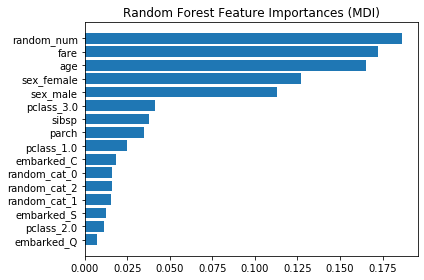

In [21]:
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [22]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

In [23]:
result

{'importances_mean': array([ 6.52439024e-02,  2.16768293e-01,  1.28048780e-02, -3.33066907e-17,
         2.74390244e-02, -1.03658537e-02,  1.18902439e-02,  9.14634146e-03,
        -5.79268293e-03]),
 'importances_std': array([0.01197981, 0.02174915, 0.00912599, 0.00510159, 0.01124335,
        0.00853659, 0.00346275, 0.01029387, 0.01152504]),
 'importances': array([[ 0.07926829,  0.05182927,  0.07621951,  0.06402439,  0.07012195,
          0.07926829,  0.04878049,  0.06402439,  0.07317073,  0.04573171],
        [ 0.17987805,  0.22560976,  0.2347561 ,  0.2347561 ,  0.20731707,
          0.17378049,  0.23780488,  0.2195122 ,  0.23170732,  0.22256098],
        [ 0.01829268,  0.02439024,  0.01219512,  0.0152439 ,  0.00914634,
          0.00914634,  0.0152439 ,  0.        ,  0.02743902, -0.00304878],
        [ 0.        , -0.00304878,  0.        , -0.00304878,  0.00609756,
          0.00609756, -0.00609756, -0.00914634,  0.00304878,  0.00609756],
        [ 0.0152439 ,  0.01829268,  0.0457317

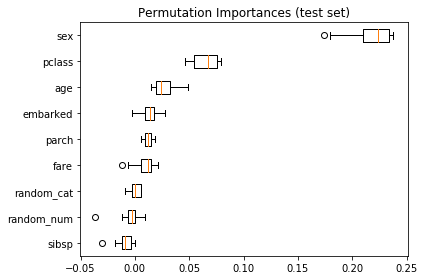

In [24]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()